# Домашнее задание №2

### Пункт 1. Создание таблицы payments в базе данных SQL

#### В ячейку ниже впишите в двойных кавычках (" "):
* в переменную **_my__path_** путь вашей папки, в которой расположены папки *applications* и *contracts* (в путь включается название самой папки, в текущем примере папка со всеми данными называется IT)
* в переменную **_mydatabase_** название созданной вами базы данных
* в переменную **_mypassword_** ваш пользовательский пароль для работы с MySQL
* в переменную **_myuser_** ваше имя пользователя MySQL (по умолчанию *root*)

In [1]:
my_path = "C:/Users/plaps/Desktop/IT"
mydatabase = "loan"
mypassword = "MySQL2018"
myuser = "root"

Для ознакомления ниже обозначены переменные, задаваемые пользователем, далее при выполнении кода он сможет сам ввести нужные значения

In [2]:
# Горизонт риска может быть задан как одной из данных переменных, так и их сочетанием

#years = 1
#months = 8
#days = 0

In [3]:
#var_name = 'age' - переменная, по которой будет построена метрика
#graph_type = 'WOE' - тип метрики, которую пользователь хочет построить
#max_tresholds = 1000 # если ROC, выбирает такое кол-во порогов  отсечения 
                                                    #(переменная является классификатором), 
                                                    # можно задать любым числом, но чем больше число, тем дольше будет выполнение
#max_bin = 10 # если WOE и разбиваем на категории (максимальное число категорий)
#force_bin = 5  # если WOE и разбиваем на категории (минимальное число категорий)

In [4]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from datetime import datetime
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse
from IPython.display import display, HTML
from sklearn import preprocessing
from datetime import timedelta
import mysql
import mysql.connector
from mysql.connector import Error
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import matplotlib.pyplot as plt
from sklearn import metrics
import statistics
import matplotlib as matplotlib
from decimal import Decimal

In [5]:
payments = pd.read_excel(my_path+"/payments.xls")
payments.head()

,Contract Number,Date,Amount Due,Amount Paid
0,100875,2016-04-05,24700.5,24700.5
1,100875,2016-05-05,24700.5,24700.5
2,100875,2016-06-05,24700.5,0.0
3,100875,2016-07-05,24700.5,0.0
4,100875,2016-08-05,24700.5,74101.5


In [6]:
# подключаемся к базе данных
database = mysql.connector.connect(user=myuser, password=mypassword,
                              host='localhost',
                              database=mydatabase,auth_plugin='mysql_native_password')
mycursor = database.cursor(buffered=True)

In [7]:
# создаем таблицу платежей (заданный порядок переменных важен, менять нельзя)
mycursor.execute(
"""CREATE TABLE payments (contract_number INT, payment_date DATE, amount_due DECIMAL(18,2), amount_paid DECIMAL(18,2))""")

In [8]:
sql = "INSERT INTO payments VALUES (%s, %s, %s, %s)"
for i in range(0, payments.shape[0]):
    val = (int(payments.iloc[i]['Contract Number']), payments.iloc[i]['Date'], payments.iloc[i]['Amount Due'],
                payments.iloc[i]['Amount Paid'])
    mycursor.execute(sql, val)

    database.commit()

In [9]:
database.close()

### Пункт 2. Соединение с базой данных SQL

Проверим, что таблица появилась в базе данных и посмотрим, как она выглядит:

In [10]:
# подключаемся к базе данных
database = mysql.connector.connect(user=myuser, password=mypassword,
                              host='localhost',
                              database=mydatabase,auth_plugin='mysql_native_password')
mycursor = database.cursor(buffered=True)

In [11]:
mycursor.execute("SELECT * FROM payments")
payments = pd.DataFrame(mycursor.fetchall())
payments.columns = [i[0] for i in mycursor.description]

In [12]:
payments.head()

,contract_number,payment_date,amount_due,amount_paid
0,100875,2016-04-05,24700.50,24700.50
1,100875,2016-05-05,24700.50,24700.50
2,100875,2016-06-05,24700.50,0.00
3,100875,2016-07-05,24700.50,0.00
4,100875,2016-08-05,24700.50,74101.50


### Пункт 3 (a). Поиск просрочек 90+ по таблице payments

По запрошенной в предыдущем пункте таблице найдём моменты просрочки 90+ через куммулятивную сумму дисбаланса между тем, что было выплачено и тем, что должно было быть уплачено по контракту на дату. Критерием определения просрочки 90+ служит отрицательный куммулятивный баланс на протяжении 4 периодов подряд, момент дефолта - дата 4-го наблюдаемого подряд дисбаланса.

In [13]:
payments['cumulative_disbalance'] = np.nan
payments['default'] = np.nan
contract_numbers = payments['contract_number'].drop_duplicates().reset_index(drop = True)

In [14]:
for i in contract_numbers:
    contract_index = payments.index[payments['contract_number'] == i].tolist()
    sum_disb = 0
    counter = 0
    for j in contract_index:
        new_sum = payments.iloc[j, payments.columns.get_loc('cumulative_disbalance')] = sum_disb + payments['amount_paid'].iloc[j]-payments['amount_due'].iloc[j]
        sum_disb = new_sum
        if new_sum < 0:
            counter = counter + 1
        else: 
            counter = 0
        if counter == 4:
            payments.iloc[j, payments.columns.get_loc('default')] = 1
        else:
            payments.iloc[j, payments.columns.get_loc('default')] = 0

Посмотрим на обновленную (в питоне, не в БД) таблицу с флагами дефолтов по контрактам (1 - дефолт, 0 - не дефолт):

In [15]:
payments.head()

,contract_number,payment_date,amount_due,amount_paid,cumulative_disbalance,default
0,100875,2016-04-05,24700.50,24700.50,0.00,0.0
1,100875,2016-05-05,24700.50,24700.50,0.00,0.0
2,100875,2016-06-05,24700.50,0.00,-24700.50,0.0
3,100875,2016-07-05,24700.50,0.00,-49401.00,0.0
4,100875,2016-08-05,24700.50,74101.50,0.00,0.0


### Пункт 3 (f). Создание таблицы по дефолтам в БД

Создаем таблицу с дефолтными контрактами следующего вида, отправляем её в БД. В данной таблице содержатся только дефолтные контракты, их даты, куммулятивный дисбаланс на дату

In [16]:
default_table = payments[payments['default'] == 1] .reset_index(drop=True)
default_table = default_table[['contract_number', 'payment_date', 'cumulative_disbalance']]
default_table.columns = ['contract_number', 'default_date', 'cumulative_disbalance']
default_table

,contract_number,default_date,cumulative_disbalance
0,100875,2017-03-05,-98802.00
1,100684,2017-12-14,-108306.00
2,100052,2017-12-30,-140112.00
3,100375,2017-01-02,-65034.00
4,100901,2016-11-03,-171882.00
5,100668,2018-06-29,-199710.00


In [17]:
mycursor.execute("""CREATE TABLE defaults (contract_number INT, default_date DATE, cumulative_disbalance
 DECIMAL(18,2), PRIMARY KEY (contract_number) )""")

In [18]:
sql = "INSERT INTO defaults VALUES (%s, %s, %s)"
for i in range(0, default_table.shape[0]):
    val = (int(default_table.iloc[i]['contract_number']), default_table.iloc[i]['default_date'], 
           default_table.iloc[i]['cumulative_disbalance'])
    mycursor.execute(sql, val)
    database.commit()

### Пункт 3 (b). Задайте свой горизонт риска

В ячейке ниже задайте свой горизонт риска. Вы можете задавать его в нескольких вариантах: в годах, в месяцах, в днях или добавить числа во все три временные переменные, будет учтена их сумма во времени. Важным условием является целочисленность вводимых параметров и чтобы горизонт риска был не меньше 90 дней.

In [19]:
years = 1
months = 8
days = 0

In [20]:
if type(years) != int or type(months) != int or type(days) != int:
    print('Ошибка: задайте целочисленные параметры!')

Выбираем на временном отрезке не менее заданного горизонта риска данные из объединенных таблиц applications, contracts и defaults  (только те данные, где известна дата начала контракта и длительность в месяцах). Получаем полную таблицу по заёмщику со всеми его характеристиками, включая метку с флагом дефолт - 1, не дефолт - 0 на заданном горизонте риска

In [21]:
mycursor.execute("""SELECT * FROM 
(SELECT DISTINCT applications.*, contracts.contract_number, contracts.amount, contracts.term_month, contracts.annuity, 
contracts.contract_date, contracts.type, defaults.default_date  
FROM applications
LEFT JOIN contracts 
ON applications.id_number = contracts.id_number
LEFT JOIN defaults
ON contracts.contract_number = defaults.contract_number
ORDER BY applications.id_number) t1
WHERE (t1.contract_date IS NOT NULL) 
AND (t1.term_month IS NOT NULL) 
AND DATE_ADD(t1.contract_date, INTERVAL (t1.term_month) MONTH) >= 
DATE_ADD(DATE_ADD(DATE_ADD(t1.contract_date, INTERVAL {0} YEAR), INTERVAL {1} MONTH), INTERVAL {2} DAY)""".format(years, 
                                                                                                                  months, days))
borrowers_defaults_data = mycursor.fetchall()
if not borrowers_defaults_data:
    print("Контракты такой длительности и более не найдены, выберите другой горизонт риска")
else:
    borrowers_defaults = pd.DataFrame(borrowers_defaults_data)
    borrowers_defaults.columns = [i[0] for i in mycursor.description]
    borrowers_defaults['default'] = 0
    borrowers_defaults.loc[borrowers_defaults['default_date']<= 
                           borrowers_defaults['contract_date']+relativedelta(days = days, months = months, years = years), 
                           'default'] = 1 #дефолты смотрим только на горизонте риска

Посмотрим на часть таблицы с заёмщиками с контрактами не менее заданного горизонта риска:

In [22]:
display(borrowers_defaults[['id_number', 'contract_number', 'amount', 'term_month', 'annuity', 'contract_date', 
                            'type', 'default_date', 'default']].head())

print("""Всего на промежутке времени не менее горизонта риска найдено заёмщиков с контрактом - """ +str(borrowers_defaults.shape[0])+""" ,
в текущей таблице максимально доступно полей (включая номер id заёмщика и номер контракта) -  """+str(borrowers_defaults.shape[1]))
print("Всего дефолтов на заданном горизонте риска - "+str(len(borrowers_defaults.loc[borrowers_defaults['default'] == 1])))

,id_number,contract_number,amount,term_month,annuity,contract_date,type,default_date,default
0,100003,100524,1293503,39,35699,2014-06-22,0,None,0
1,100004,100552,135000,23,6750,2017-08-01,1,None,0
2,100007,100797,513000,26,21866,2017-06-09,0,None,0
3,100008,100929,490496,21,27518,2015-03-22,0,None,0
4,100009,100022,1560726,41,41301,2015-02-11,0,None,0


Всего на промежутке времени не менее горизонта риска найдено заёмщиков с контрактом - 46 ,
в текущей таблице максимально доступно полей (включая номер id заёмщика и номер контракта) -  24
Всего дефолтов на заданном горизонте риска - 5


Посмотрим, какие из этих контрактов дефолтные:

In [23]:
borrowers_defaults.loc[borrowers_defaults['default'] == 1]

,id_number,issue_date,children,family,income,age_of_car,application_date,age,education,employed_by,...,marital_status,position,contract_number,amount,term_month,annuity,contract_date,type,default_date,default
17,100031,2011-12-06,0,1,112500,NaN,2016-12-06,53,2,1,...,4,2.0,100684,979992,39,27077,2016-06-14,0,2017-12-14,1
25,100047,2013-02-11,0,2,202500,NaN,2016-08-27,50,2,1,...,1,5.0,100052,1193580,37,35028,2016-08-30,0,2017-12-30,1
27,100049,2004-05-04,0,2,135000,NaN,2016-01-05,39,2,17,...,0,9.0,100375,288873,21,16259,2016-02-05,0,2017-01-02,1
28,100050,2003-05-18,0,1,108000,NaN,2015-11-27,67,0,25,...,3,NaN,100901,746280,20,42971,2015-03-12,0,2016-11-03,1
32,100056,2011-12-28,0,2,360000,3.0,2016-11-28,52,2,21,...,1,5.0,100668,1506816,33,49928,2016-11-29,0,2018-06-29,1


### Пункт 3. Подготовка к пунктам (d) и (e)

Создаём список переменных по таблице applications, добавляем к нему параметр default

In [24]:
mycursor.execute("""SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_SCHEMA = '{0}' AND 
TABLE_NAME = 'applications'""".format(mydatabase))
applic_cols = mycursor.fetchall()
all_applic_cols = []
for i in range(0, len(applic_cols)):
    all_applic_cols.append(applic_cols[i][0])
all_applic_cols.append('default')

Создаем список, чтобы удалить лишние в анализе переменные (можно корректировать), например, id, даты

In [25]:
drop_list = ['id_number','application_date','issue_date']
for i in drop_list:
    all_applic_cols.remove(i)

Все данные, которые понадобятся для анализа

In [26]:
borrowers_defaults_short = borrowers_defaults[all_applic_cols]
borrowers_defaults_short.head()

,age,age_of_car,children,education,employed_by,family,gender,house_ownership,housing,income,income_type,marital_status,position,default
0,50,NaN,0,0,14,2,0,0,0,270000,2,1,3.0,0
1,54,26.0,0,2,5,1,1,1,0,67500,3,3,5.0,0
2,55,NaN,0,2,13,1,1,1,0,121500,3,3,3.0,0
3,50,NaN,0,2,12,2,1,1,0,99000,2,1,5.0,0
4,40,17.0,1,0,1,3,0,1,0,171000,0,1,0.0,0


Создадим список категориальных переменных, чтобы в дальнейшим именно по ним строить WOE

In [27]:
mycursor.execute("""SELECT DISTINCT column_name FROM applications_dict""")
char_vars =  mycursor.fetchall()
list_char_vars = []
for i in range(0, len(char_vars)):
    list_char_vars.append(char_vars[i][0])
additionally_append = ['family','children']  # что ещё считаем нужным рассматривать как категориальную
for i in range (0, len(additionally_append)):
    list_char_vars.append(additionally_append[i])

Для вычисления метрик WOE, IV, за основу взят код из ресурса https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb с некоторыми преобразованиями. По всем категориальным переменным применяется стандартная процедура вычисления WOE и IV, для непрерывных первоначально производится разбиение на категории. Данный код  категоризует по квантилям.

In [28]:
# define a binning function
def mono_bin(Y, X, max_bin, force_bin):
    n = max_bin
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True, sort = True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    np.seterr(divide='ignore')
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    np.seterr(divide='ignore')
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3["CATEGORY_NAME"] = "NO_CATEGORY"

    d3 = d3[['VAR_NAME', 'CATEGORY_NAME', 'MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 
             'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True, sort = True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    np.seterr(divide='ignore')
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    np.seterr(divide='ignore')
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3["CATEGORY_NAME"] = "NO_CATEGORY"
    d3 = d3[['VAR_NAME','CATEGORY_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, default, max_bin, force_bin):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2 and i not in list_char_vars:
                conv = mono_bin(default, df1[i], max_bin, force_bin)
                conv["VAR_NAME"] = i
                for j in range(0, len(conv)):
                    conv.iloc[j, conv.columns.get_loc('CATEGORY_NAME')] = str(conv['MIN_VALUE'][j])+' - '+str(conv['MAX_VALUE'][j])
                
                count = count + 1
            else:
                conv = char_bin(default, df1[i])
                conv["VAR_NAME"] = i
                if i not in additionally_append:
                    mycursor.execute("""SELECT category, encoding FROM applications_dict WHERE column_name = '{0}' """.format(i))
                    keys = mycursor.fetchall()

                    for j in range(0, len(keys)):
                        conv.loc[conv['MIN_VALUE'] == keys[j][1], 'CATEGORY_NAME'] =  keys[j][0]
                else:
                    for j in range(0, len(conv)):
                        conv.iloc[j, conv.columns.get_loc('CATEGORY_NAME')] = str(conv['MIN_VALUE'][j])
                
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

Данная функция строит ROC-кривую по переменной

In [29]:
def ROC1 (var_name, max_tresholds):
        less_then_treshold  = 0
        more_then_treshold  = 1
        TPR = []
        FPR = []
        defaults_true = list(borrowers_defaults_short.default)
        defaults_classified = pd.DataFrame(borrowers_defaults_short[var_name])
        tresholds = np.arange(borrowers_defaults_short[[var_name]].min()[0],borrowers_defaults_short[[var_name]].max()[0]+2,
                              (borrowers_defaults_short[[var_name]].max()[0]-
                               borrowers_defaults_short[[var_name]].min()[0])/(max_tresholds-1))
       
        for i in tresholds:

            TP = 0
            TN = 0
            FP = 0
            FN = 0
            
            defaults_classified.loc[defaults_classified[var_name] < i, 'defaults_classified'] = less_then_treshold
            defaults_classified.loc[defaults_classified[var_name] >= i, 'defaults_classified'] = more_then_treshold
            
            for j in range(0, len(defaults_classified)):
                if defaults_classified['defaults_classified'][j] == 1 and defaults_true[j] == 1:
                    TP += 1
                if defaults_classified['defaults_classified'][j] == 0 and defaults_true[j] == 0:
                    TN += 1
                if defaults_classified['defaults_classified'][j] == 1 and defaults_true[j] == 0:
                    FP += 1  
                if defaults_classified['defaults_classified'][j] == 0 and defaults_true[j] == 1:
                    FN += 1

            TPR_tr = TP/(TP+FN)
            FPR_tr = FP/(FP+TN)
            
            TPR.append(TPR_tr)
            FPR.append(FPR_tr)
            
        ROC_AUC = metrics.auc(FPR,TPR)
        GINI = 2*ROC_AUC-1    
        return TPR, FPR, GINI

In [30]:
def ROC2 (var_name, treshold):
        less_than_treshold  = 0
        more_than_treshold  = 1
        defaults_true = list(borrowers_defaults_short.default)
        defaults_classified = pd.DataFrame(borrowers_defaults_short[var_name])
        defaults_classified.loc[defaults_classified[var_name] < treshold, 'defaults_classified'] = less_than_treshold
        defaults_classified.loc[defaults_classified[var_name] >= treshold, 'defaults_classified'] = more_than_treshold
        defaults_classified = list(defaults_classified.defaults_classified)
        FPR, TPR, thresholds = metrics.roc_curve(defaults_true, defaults_classified)
        ROC_AUC = metrics.auc(FPR,TPR)
        GINI = 2*ROC_AUC-1
        return TPR, FPR, GINI

Данная функция строит графики в зависимости от того, какой тип переменной и графика выбран, а также их параметров

In [31]:
def plot_metric(var_name, graph_type):
    if var_name in list_char_vars and graph_type == 'ROC':
        print()
        print('Для категориальной переменной не строится ROC-кривая, будет построен график WOE')
        graph_type = 'WOE'
    if graph_type == 'WOE':
        small_df = final_iv[final_iv['VAR_NAME'] == var_name]
        display(small_df)
        fig = plt.figure(1, [10, 5])
        plt.bar(small_df['CATEGORY_NAME'], small_df['WOE'])
        plt.title('WOE for '+ var_name)
        plt.grid(True)
        plt.xlabel('Category', fontdict=None, labelpad=15)
        plt.ylabel('WOE', fontdict=None, labelpad=15)
        if small_df.shape[0] <= 4:
            rotation_type = 'horizontal'
        else:
            rotation_type = 'vertical'
        plt.xticks(rotation=rotation_type)

    if graph_type == 'ROC' and var_name not in list_char_vars:
        TPR, FPR, GINI = ROC1(var_name, max_tresholds)
       # TPR, FPR, GINI = ROC2(var_name, treshold)
        fig = plt.figure(1, [10, 5])        
        plt.xlabel('False Positive Rate', fontdict=None, labelpad=15)
        plt.ylabel('True Positive Rate', fontdict=None, labelpad=15)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title('ROC for '+var_name)
        plt.plot(FPR, TPR, color='blue', lw=2, label='GINI=%0.2f'% GINI)
        plt.legend(loc="lower right")
        plt.show()

### Пункт 3 (d+e). Выбор переменной из таблицы applications и построение метрики

#### В ячейку ниже впишите по образцу:
* в переменную **_var__name_** желаемую переменную из таблицы applications. Список предлагаемых переменных предложен под ячейкой для ввода
* в переменную **_graph__type_** тип метрики, которую вы хотите построить. Вписать можно либо значение **_'ROC'_** для непрерывных переменных, либо значение **_'WOE'_** для категориальных переменных, либо для категоризируемых по квантилям в ходе выполнения кода непрерывных переменных.<br><br>
Если вы выбрали построение **_'ROC'_**:<br><br>
* в переменную **_max__tresholds_** максимальное количество порогов отсечения, используемых при построении ROC (влияет как на качество построения, так и на скорость исполнения, можете оставить дефолтное значение 1000)<br><br>
Если вы выбрали построение **_'WOE'_** по непрерывной переменной:<br><br>
* в переменную **_max__bin_** максимальное число категорий, которое вы хотите получить
* в переменную **_force__bin_** минимальное число категорий, которое вы хотите получить<br><br>
По умолчанию ниже приведен пример для категориальной переменной, а после этого в самом конце - для непрерывной 

#### Пример WOE и IV для категоризированного возраста

In [32]:
var_name = 'age'
graph_type = 'WOE'
treshold = statistics.median(list(borrowers_defaults_short[var_name])) # если ROC
max_bin = 10 # если WOE и разбиваем на бакеты
force_bin = 5 # если WOE и разбиваем на бакеты
max_tresholds = 100

In [33]:
list(borrowers_defaults_short.loc[:, borrowers_defaults_short.columns != 'default'])

['age',
 'age_of_car',
 'children',
 'education',
 'employed_by',
 'family',
 'gender',
 'house_ownership',
 'housing',
 'income',
 'income_type',
 'marital_status',
 'position']

In [34]:
if graph_type == 'WOE':
    force_bin = force_bin+1
    final_iv, IV = data_vars(borrowers_defaults_short.drop('default', axis=1),borrowers_defaults.default, max_bin, force_bin)

Выполним построение для выбранной переменной (к графику WOE прилагается таблица):

,VAR_NAME,CATEGORY_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,age,21 - 35,21.0,35.0,10,0.0,0.000000,10.0,1.000000,0.0,0.243902,0.000000,0.195554
1,age,36 - 41,36.0,41.0,9,1.0,0.111111,8.0,0.888889,0.2,0.195122,0.024693,0.195554
2,age,43 - 50,43.0,50.0,9,1.0,0.111111,8.0,0.888889,0.2,0.195122,0.024693,0.195554
3,age,51 - 55,51.0,55.0,9,2.0,0.222222,7.0,0.777778,0.4,0.170732,0.851371,0.195554
4,age,56 - 67,56.0,67.0,9,1.0,0.111111,8.0,0.888889,0.2,0.195122,0.024693,0.195554


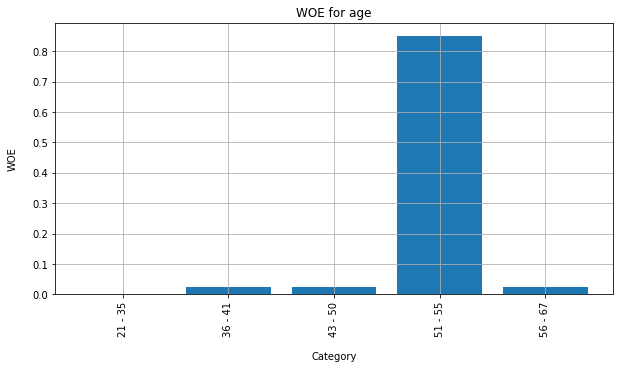

In [35]:
plot_metric(var_name, graph_type)

При выборе построения WOE также будет выводиться столбчатая диаграмма значений IV по убыванию для всех переменных

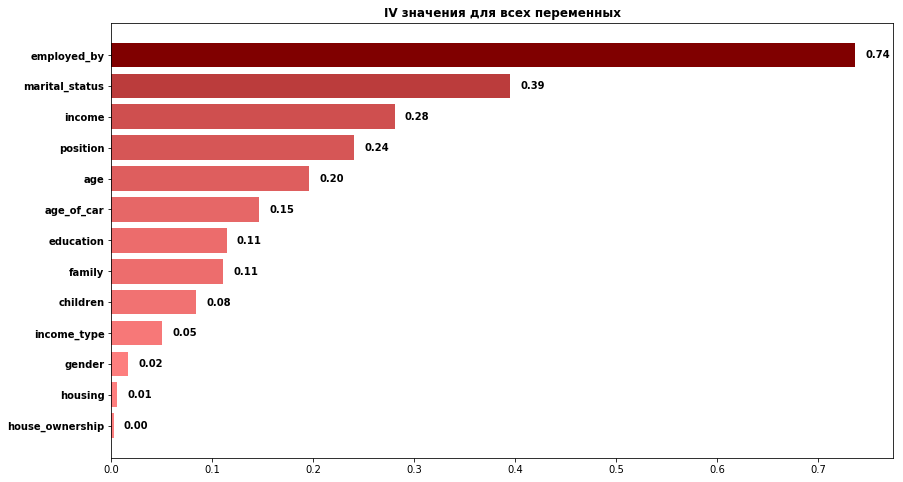

In [36]:
if graph_type == 'WOE':
    IV_sort = IV.sort_values('IV')
    iv_scores = np.array(IV_sort['IV'])
    data_normalizer = matplotlib.colors.Normalize()
    color_map = matplotlib.colors.LinearSegmentedColormap("my_map",{"red": [(0, 1.0, 1.0),(1.0, .5, .5)],
                                                                    "green": [(0, 0.5, 0.5),(1.0, 0, 0)],
                                                                    "blue": [(0, 0.50, 0.5),(1.0, 0, 0)]})

    N = len(IV_sort['IV'])
    x_nums = np.arange(1, N+1)

    fig = plt.figure(1, [14, 8]) 
    plt.barh(x_nums, IV_sort['IV'], align="center", color=color_map(data_normalizer(iv_scores)))
    plt.yticks(x_nums, IV_sort['VAR_NAME'],  fontweight='bold')
    for i, v in enumerate(iv_scores):
        #v = round(Decimal(v),2)
        plt.text(v+0.01, i+0.9, str(round(Decimal(v),2)), color='black',  fontweight='bold')
    plt.title('IV значения для всех переменных', fontweight='bold')
    plt.show()

#### Пример ROC для непрерывного income

In [37]:
var_name = 'income'
graph_type = 'ROC'
treshold = statistics.median(list(borrowers_defaults_short[var_name])) # если ROC
max_bin = 10 # если WOE и разбиваем на бакеты
force_bin = 5 # если WOE и разбиваем на бакеты
max_tresholds = 1000

In [38]:
if graph_type == 'WOE':
    force_bin = force_bin+1
    final_iv, IV = data_vars(borrowers_defaults_short,borrowers_defaults.default, max_bin, force_bin)

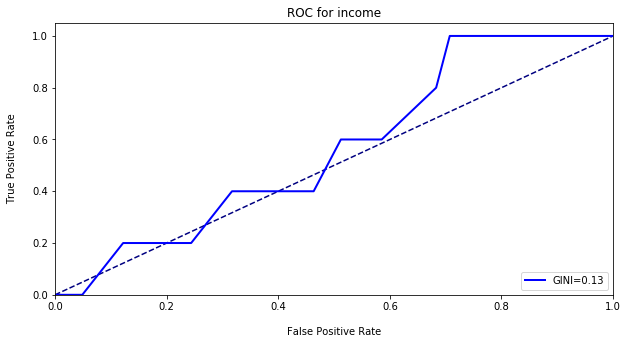

In [39]:
plot_metric(var_name, graph_type)

In [40]:
if graph_type == 'WOE':
    IV_sort = IV.sort_values('IV')
    iv_scores = np.array(IV_sort['IV'])
    data_normalizer = matplotlib.colors.Normalize()
    color_map = matplotlib.colors.LinearSegmentedColormap("my_map",{"red": [(0, 1.0, 1.0),(1.0, .5, .5)],
                                                                    "green": [(0, 0.5, 0.5),(1.0, 0, 0)],
                                                                    "blue": [(0, 0.50, 0.5),(1.0, 0, 0)]})

    N = len(IV_sort['IV'])
    x_nums = np.arange(1, N+1)

    fig = plt.figure(1, [14, 8]) 
    plt.barh(x_nums, IV_sort['IV'], align="center", color=color_map(data_normalizer(iv_scores)))
    plt.yticks(x_nums, IV_sort['VAR_NAME'],  fontweight='bold')
    for i, v in enumerate(iv_scores):
        #v = round(Decimal(v),2)
        plt.text(v+0.01, i+0.9, str(round(Decimal(v),2)), color='black',  fontweight='bold')
    plt.title('IV значения для всех переменных', fontweight='bold')
    plt.show()

In [41]:
database.close()